### Import libraries

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
import seaborn as sns

# pd.set_option("display.max_colwidth", False)
# pd.set_option("expand_frame_repr", False)

### Collect past price data 

In [2]:
### Load past prices of SPX constituents

# Load the existing csv file
past_price_df = pd.read_csv(r"spx_close_price_18.12.23.csv")

# Get list of column names and stock names
column_names = list(past_price_df.columns)
stock_names = column_names[1:]
past_price_df = past_price_df.rename(columns={column_names[0]: "Date"})

# Remove duplicate dates so that we can set Date as index
past_price_df.drop_duplicates(subset=['Date'])

# Convert dates to standard format for plotting
past_price_df['Date'] = pd.to_datetime(past_price_df['Date'], format="%d/%m/%Y") # y for 2 digit years, Y for 4 digit years

# Fill all missing prices with the previous known price
past_price_df = past_price_df.bfill().ffill()

# Set index to date
past_price_df = past_price_df.set_index("Date")

In [3]:
### Append price of SPX (index)

# Get past price history of index (SPX)
past_spx_df = pd.read_csv(r"spx_index_close_price_18.12.23.csv", index_col=0)
past_spx_df = past_spx_df[~past_spx_df.index.duplicated()]

# Convert dates to standard format - the index must be in the same format so that we can join the dataframes
past_spx_df.index = pd.to_datetime(past_spx_df.index, format="%d/%m/%Y") # y for 2 digit years, Y for 4 digit years

# Append .SPX price to past price data
past_price_df = pd.concat([past_price_df, past_spx_df], axis=1)

display(past_price_df.head())

,POOL.OQ,CHRW.OQ,AJG.N,CNP.N,AMCR.N,WM.N,BA.N,FOX.OQ,WY.N,MCD.N,...,NRG.N,MKTX.OQ,LMT.N,DLR.N,PSX.N,SCHW.N,SNPS.OQ,J.N,AVY.N,.SPX
2022-12-19,308.14,93.51,185.09,29.98,12.02,157.59,185.68,27.63,29.891429,265.83,...,31.54,271.48,481.79,99.39,100.61,78.26,323.39,98.958393,176.48,3817.66
2022-12-20,303.77,92.38,186.89,29.97,12.05,157.79,188.29,28.10,29.968993,267.25,...,31.66,266.65,486.15,98.74,102.64,79.56,324.43,98.707907,178.36,3821.62
2022-12-21,311.68,92.92,189.48,30.53,12.10,159.27,196.00,28.39,30.162904,268.16,...,32.42,277.98,487.65,100.45,103.35,81.25,330.22,101.279556,180.93,3878.44
2022-12-22,305.08,92.46,188.03,30.31,11.98,157.73,188.25,28.54,30.104731,265.77,...,31.89,281.76,479.30,99.86,100.53,80.80,321.72,100.093926,178.81,3822.39
2022-12-23,305.60,93.08,188.41,30.69,12.06,159.21,189.06,28.85,30.531336,267.57,...,31.91,280.85,483.29,100.87,103.94,81.77,320.21,100.912178,181.11,3844.82


### Plot some prices

Make a utility function 

// To call:
plot_price(ticker, dataframe) 

// Returns
Graph of price against date

### Get some metrics

In [4]:
### Calculate annual returns and select best performing stocks

# Calculate expected daily returns
daily_returns = past_price_df.pct_change() 
daily_log_returns = np.log(1.0 + daily_returns)

# Calculate expected annualised returns (pd.Series sorted in descending order)
annualised_log_returns = (daily_log_returns.mean(axis=0) * 252)
annualised_returns = np.exp(annualised_log_returns) - 1.0

# Get top n stocks based on annual returns
n = 50
top_n_stocks = annualised_returns.drop(columns=".SPX").sort_values(ascending=False).index[:n]

C:\Users\zeyuan\AppData\Local\Temp\ipykernel_6548\2246794030.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = past_price_df.pct_change()


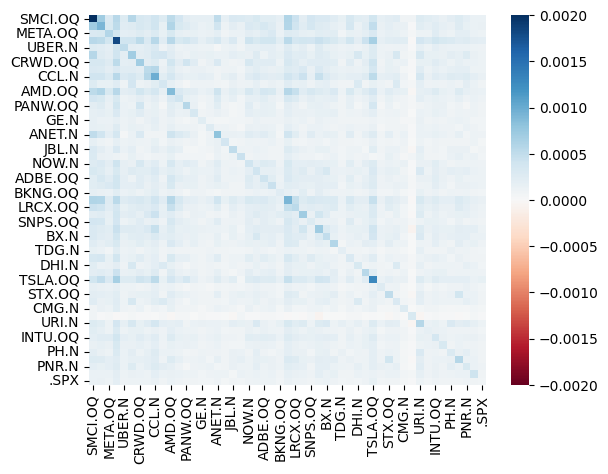

In [5]:
### Calculate covariance matrix of selected stocks, with SPX

# Calculate covariance matrix, diagonal terms represent variance
covariance_matrix = daily_log_returns[top_n_stocks.append(pd.Index([".SPX"]))].cov()

# Plot heatmap of covriance matrix of top n stocks with SPX
sns.heatmap(covariance_matrix, vmin=-0.002, vmax=0.002, cmap="RdBu", annot=False, fmt="0.0f")
plt.show()

### Naive optimisation

In [6]:
### Functions for mean variance optimisation

def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252)
    ret = np.sum(annualised_log_returns[top_n_stocks] * weights) * 252

    # Calculate the volatility, remember to annualize them (252), also remove .SPX from covariance matrix
    vol = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix.iloc[:-1, :-1] * 252, weights)))

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return -1*get_metrics(weights)[2]

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

In [7]:
### Perform Sharpe ratio optimisation using scipy.minimize

num_stocks = n

# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for stock in range(num_stocks))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = num_stocks * [1 / num_stocks]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1113.5142050233942
       x: [ 3.619e-03  5.442e-03 ...  2.421e-13  7.284e-14]
     nit: 78
     jac: [ 4.272e-04 -5.112e-03 ...  4.417e+02  3.069e+02]
    nfev: 3914
    njev: 74
--------------------------------------------------------------------------------


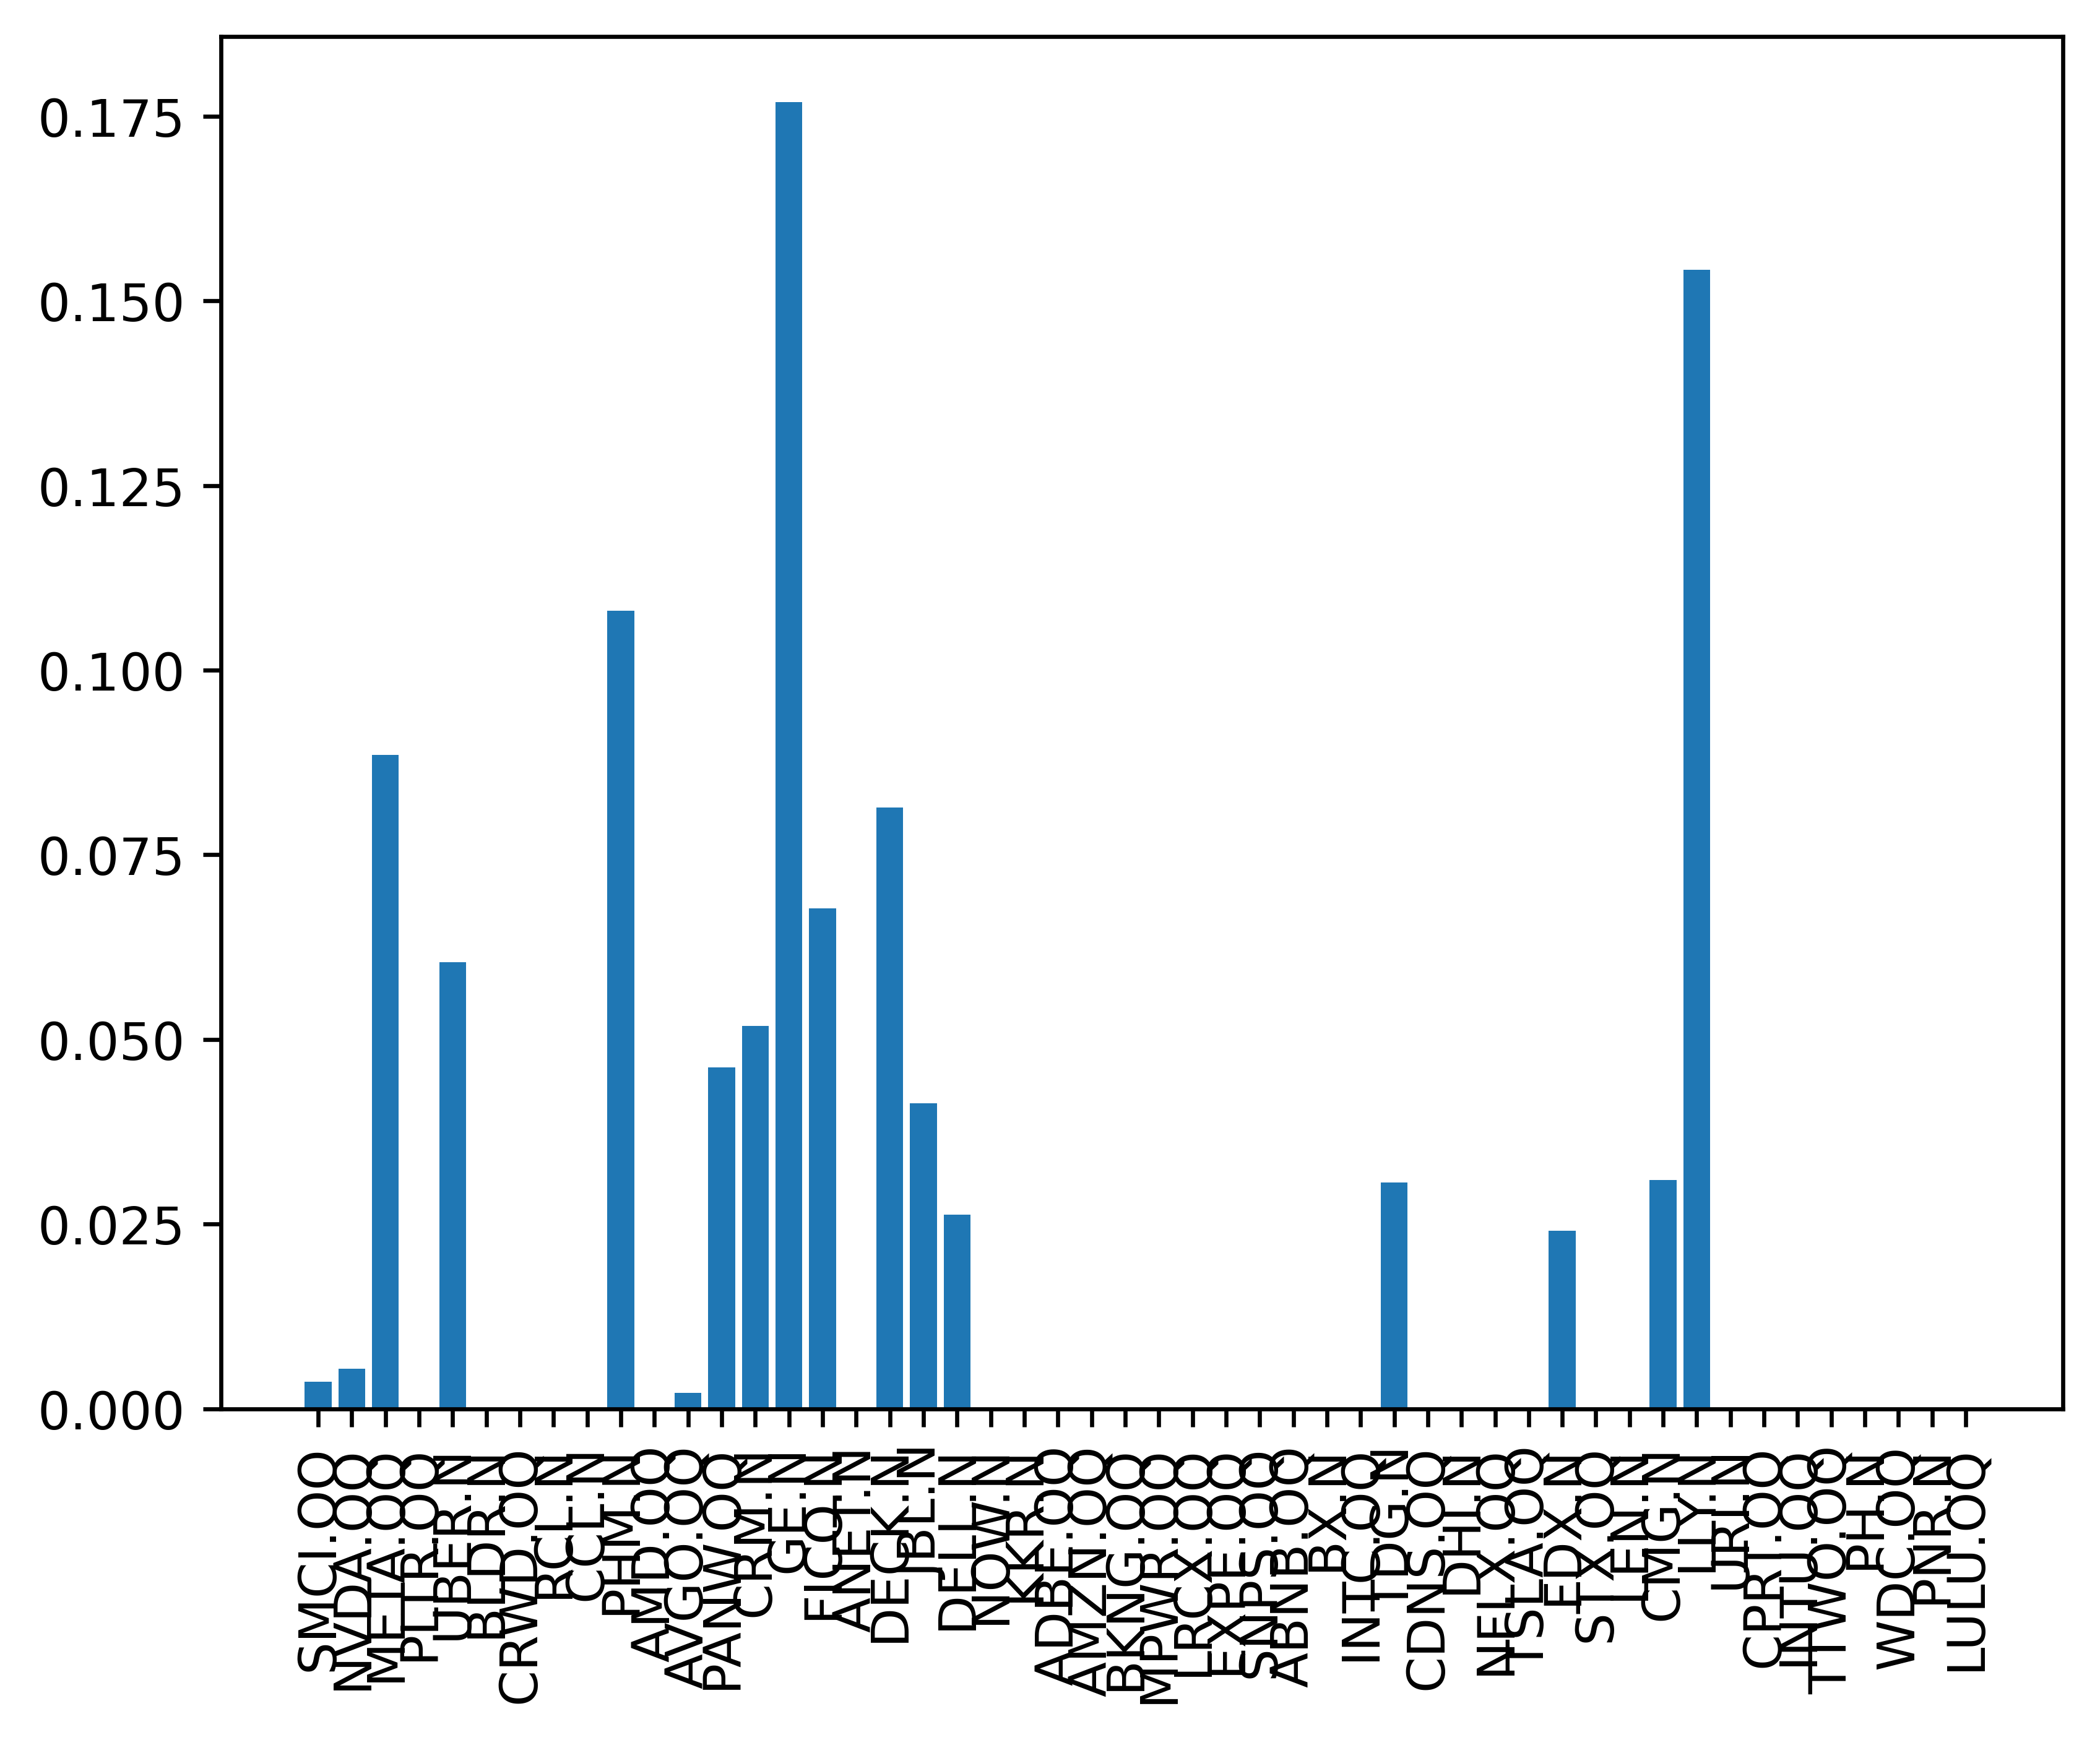

In [8]:
### Plot long portfolio weights

portfolio_weights = optimized_sharpe.x
portfolio_stocks = top_n_stocks

plt.figure(dpi=600)
plt.bar(portfolio_stocks, portfolio_weights)
plt.tick_params(axis='x', labelrotation=90)
plt.show()

### Beta hedging

Hedging methodology 1.:

$$\beta = \frac{\text{Cov}[\text{ret}_{stock}, \text{ret}_{index}]}{\text{Var}[\text{ret}_{index}]}$$


Hedging methodology 2.:

$$\beta = 0.2 + 0.8 \times \frac{\text{Cov}[\text{ret}_{stock}, \text{ret}_{index}]}{\text{Var}[\text{ret}_{index}]}$$

In [9]:
### Beta hedging

# Get past prices for long and short portfolios
past_long_df = past_price_df[top_n_stocks.append(pd.Index([".SPX"]))]
past_short_df = past_price_df[pd.Index([".SPX"])]

# Get covariance of stocks and index (SPX)
long_cov = covariance_matrix.iloc[:-1, -1] # all rows except last, last column
short_cov = np.zeros((1, 1))

# Calculate variance of index
index_var = covariance_matrix.iloc[-1, -1]

# Get beta values for hedging
#long_betas = 1.0*(long_cov/index_var) # method 1
long_betas = 0.2 + 0.8*(long_cov/index_var) # method 1
short_betas = np.zeros(1)

# Get weights for long portfolio
long_weights = portfolio_weights
short_weights = np.array([])
print(short_weights)

# Calculate total hedge on long portfolio
long_hedge = (long_weights * long_betas).sum()
short_hedge = 0.0

# Append long hedge to short portfolio
long_weights = np.append(long_weights, short_hedge)
short_weights = np.append(short_weights, long_hedge)

# Normalise portfolio weights
sum_of_weights = long_weights.sum() + short_weights.sum()
long_weights = long_weights/sum_of_weights
short_weights = short_weights/sum_of_weights

# Convert long and short weights to series
long_weights = pd.Series(index=top_n_stocks.append(pd.Index([".SPX"])), data=long_weights)
short_weights = pd.Series(index=pd.Index([".SPX"]), data=short_weights)

[]


In [10]:
print(long_weights)
print(short_weights)

print(long_weights.sum() + short_weights.sum())

SMCI.OQ    1.798226e-03
NVDA.OQ    2.703604e-03
META.OQ    4.398393e-02
PLTR.OQ    2.980020e-13
UBER.N     3.004595e-02
BLDR.N     1.033608e-13
CRWD.OQ    3.665721e-08
RCL.N      4.660602e-08
CCL.N      2.183844e-13
PHM.N      5.368278e-02
AMD.OQ     1.452228e-13
AVGO.OQ    1.058522e-03
PANW.OQ    2.298247e-02
CRM.N      2.573963e-02
GE.N       8.790742e-02
FICO.N     3.367542e-02
ANET.N     4.350567e-08
DECK.N     4.045444e-02
JBL.N      2.054059e-02
DELL.N     1.305521e-02
NOW.N      6.492902e-14
KKR.N      7.044298e-14
ADBE.OQ    8.468657e-14
AMZN.OQ    1.393925e-13
BKNG.OQ    4.222151e-08
MPWR.OQ    4.295163e-13
LRCX.OQ    1.357781e-13
EXPE.OQ    7.071138e-14
SNPS.OQ    1.404309e-09
ABNB.OQ    1.873403e-13
BX.N       1.283931e-13
INTC.OQ    5.128415e-14
TDG.N      1.521015e-02
CDNS.OQ    1.489201e-14
DHI.N      4.698773e-14
NFLX.OQ    5.483887e-09
TSLA.OQ    3.654856e-13
FDX.N      1.197912e-02
STX.OQ     2.438346e-08
LEN.N      1.210165e-13
CMG.N      1.538944e-02
LLY.N      7.662

### Test on future returns

In [11]:
# Load the existing csv file
future_price_df = pd.read_csv(r"spx_close_price_18.12.24.csv")

# Get list of column names and stock names
column_names = list(future_price_df.columns)
stock_names = column_names[1:]
future_price_df = future_price_df.rename(columns={column_names[0]: "Date"})

# Remove duplicate dates so that we can set Date as index
future_price_df.drop_duplicates(subset=['Date'])

# Convert dates to standard format for plotting
future_price_df['Date'] = pd.to_datetime(future_price_df['Date'], format="%d/%m/%Y") # y for 2 digit years, Y for 4 digit years

# Fill all missing prices with the previous known price
future_price_df = future_price_df.bfill().ffill()

# Set index to date
future_price_df = future_price_df.set_index("Date")

In [12]:
# Get future price history of index (SPX)
future_spx_df = pd.read_csv(r"spx_index_close_price_18.12.24.csv", index_col=0)
future_spx_df = future_spx_df[~future_spx_df.index.duplicated()]

# Rescale for plotting
scaled_future_spx_df = future_spx_df[[".SPX"]].to_numpy().reshape(future_spx_df.shape[0])
scaled_future_spx_df = scaled_future_spx_df/scaled_future_spx_df[0]

In [13]:
# Convert dates to standard format - the index must be in the same format so that we can join the dataframes
future_spx_df.index = pd.to_datetime(future_spx_df.index, format="%d/%m/%Y") # y for 2 digit years, Y for 4 digit years

# Add future .SPX to future price df
future_price_df = pd.concat([future_price_df, future_spx_df], axis=1)

In [14]:
future_long_price_df = future_price_df[top_n_stocks.append(pd.Index([".SPX"]))]
future_short_price_df = future_price_df[pd.Index([".SPX"])]

In [15]:
# Compute future daily returns, shifted up one day
future_long_daily_returns = future_long_price_df.pct_change()
long_returns_tomorrow = future_long_daily_returns.shift(-1)

future_short_daily_returns = -1.0*future_short_price_df.pct_change()
short_returns_tomorrow = future_short_daily_returns.shift(-1)

In [16]:
dates = []
cumulative_long_values = []
cumulative_short_values = []
cumulative_portfolio_values = []

for idx in range(len(long_returns_tomorrow.index)):

    # Get the date
    date = long_returns_tomorrow.index[idx]

    # Calculate portfolio value today
    cumulative_long_value = long_weights.sum()
    cumulative_short_value = short_weights.sum()

    # Calculate total portfolio value
    cumulative_portfolio_value = cumulative_long_value + cumulative_short_value

    # Set long portfolio value to portfolio value tomorrow
    long_weights = long_weights * (1.0 + long_returns_tomorrow.iloc[idx, :])
    short_weights = short_weights * (1.0 + short_returns_tomorrow.iloc[idx, :])

    # Append daily returns that are not NaNs
    if cumulative_portfolio_value != np.nan:
        dates.append(date)
        cumulative_long_values.append(cumulative_long_value)
        cumulative_short_values.append(cumulative_short_value)
        cumulative_portfolio_values.append(cumulative_portfolio_value)

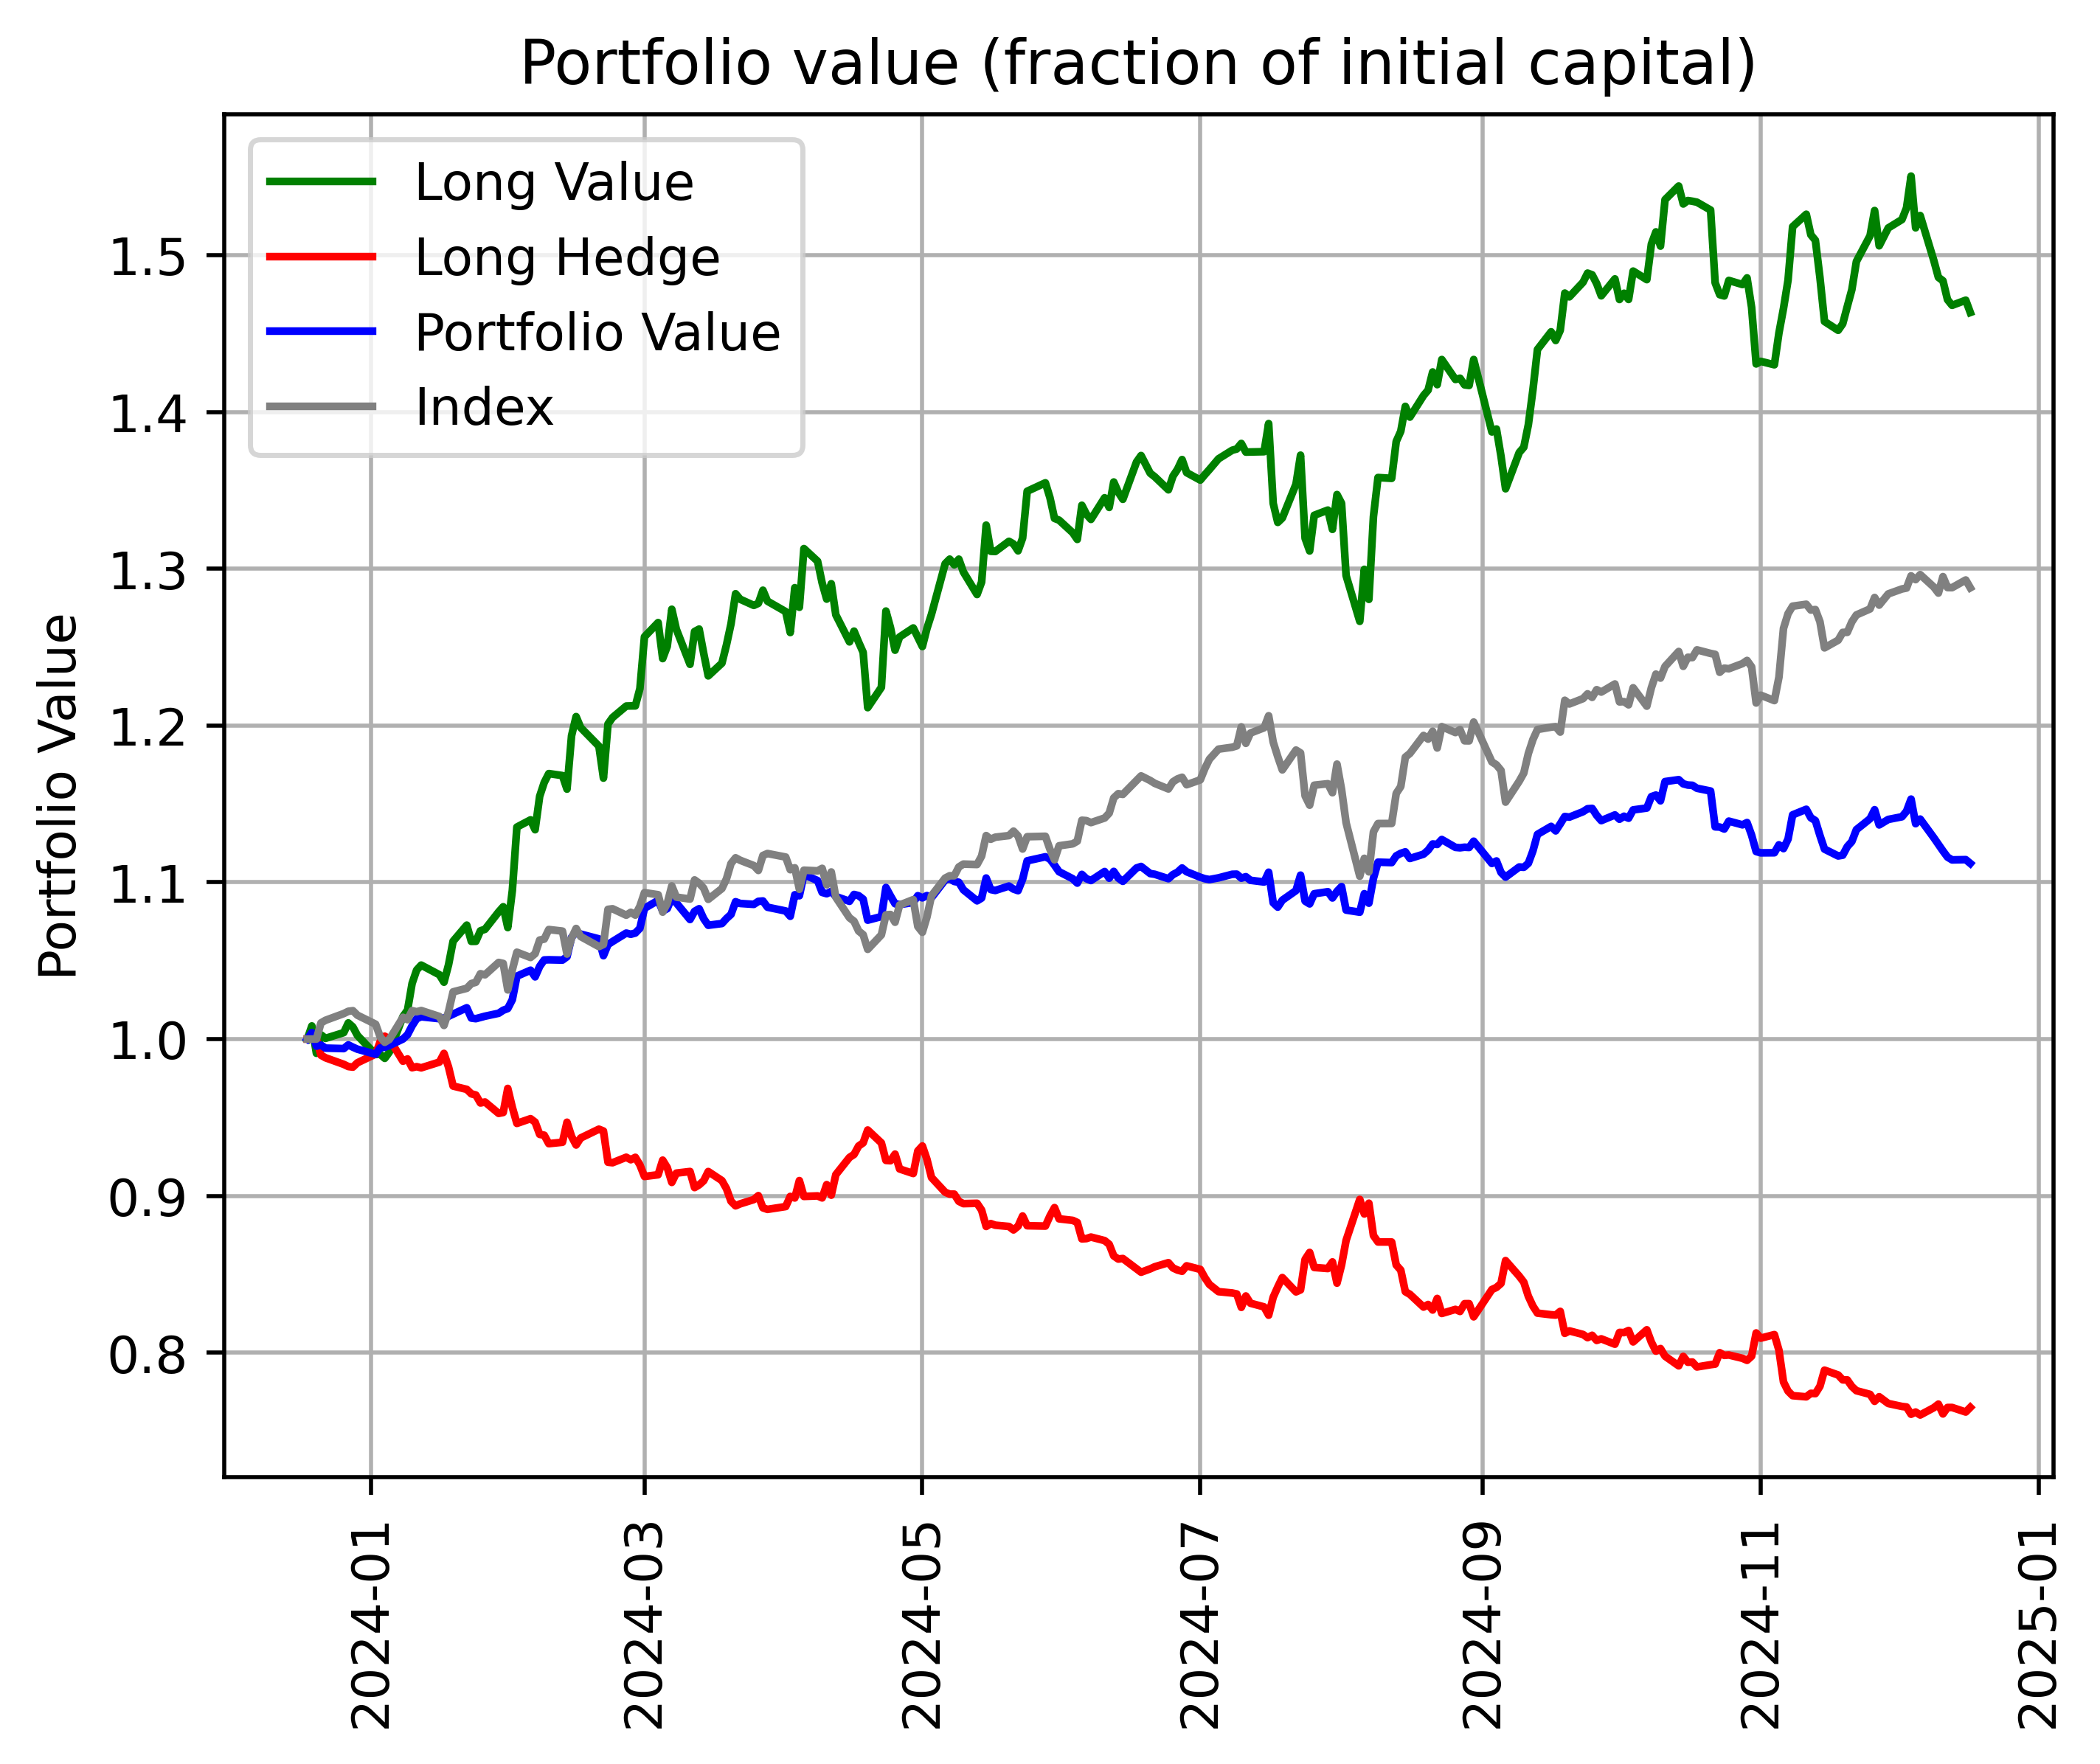

In [17]:
# Plot total returns with time
plt.figure(dpi=500)
plt.plot(dates, np.asarray(cumulative_long_values/cumulative_long_values[0]), label="Long Value", c="green")
plt.plot(dates, np.asarray(cumulative_short_values/cumulative_short_values[0]), label="Long Hedge", c="red")
plt.plot(dates, np.asarray(cumulative_portfolio_values), label="Portfolio Value", c="blue")
plt.plot(dates, scaled_future_spx_df, label="Index", c="gray")
plt.tick_params(axis='x', labelrotation=90)
plt.title("Portfolio value (fraction of initial capital)")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.show()

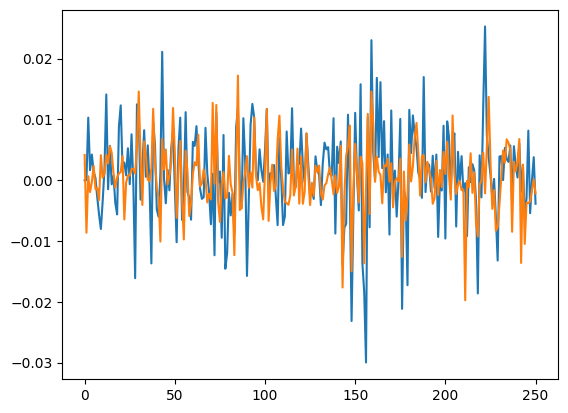

In [18]:
index_returns = np.diff(scaled_future_spx_df)/scaled_future_spx_df[:-1]
portfolio_returns = np.diff(np.asarray(cumulative_portfolio_values))/np.asarray(cumulative_portfolio_values)[:-1]
plt.plot(index_returns)
plt.plot(portfolio_returns)
plt.show()

cov_matrix = np.cov(index_returns, portfolio_returns)

In [19]:
index_sharpe = (np.cumprod(1.0+index_returns)[-1]-1.0)/np.sqrt(cov_matrix[0, 0]*252)
portfolio_sharpe = (np.cumprod(1.0+portfolio_returns)[-1]-1.0)/np.sqrt(cov_matrix[1, 1]*252)

print("Index Sharpe: ", index_sharpe)
print("Portfolio Sharpe: ", portfolio_sharpe)
print("Correlation: ", cov_matrix[0, 1]/np.sqrt(cov_matrix[0, 0]*cov_matrix[1, 1]))

Index Sharpe:  2.3746309180742724
Portfolio Sharpe:  1.3319221881159322
Correlation:  0.517794664666514
